In [ ]:
# Cell 1: create merged atlas function
# Complete atlas creation cell with all necessary imports and path setup
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
import matplotlib.pyplot as plt
import json
import re
from scipy.stats import pearsonr

# Define paths (adjust these to match your existing paths)
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results'
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas_improved():
    """
    Create and validate a merged atlas where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas (Improved Version) ===")
    
    # Load Wang ROIs - pIPS and LO
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels")
    
    # Validate spatial dimensions and resolution
    vox_dims = {}
    for roi_name, roi_img in rois.items():
        vox_dims[roi_name] = roi_img.header.get_zooms()[:3]
    atlas_dims = atlas_img.header.get_zooms()[:3]
    
    # Check for dimension mismatches
    for roi_name, dims in vox_dims.items():
        if not np.allclose(dims, atlas_dims, rtol=1e-3):
            print(f"WARNING: Resolution mismatch between {roi_name} ({dims}) and atlas ({atlas_dims})")
            print(f"Resampling may be needed for proper integration")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Set up a figure for quality control visualization
    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plotting.plot_roi(atlas_img, title="Original Schaefer Atlas", 
                     cmap='nipy_spectral', colorbar=True, figure=plt.gcf(), 
                     axes=plt.gca(), draw_cross=False)
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Validate ROI mask isn't empty
        if np.sum(roi_mask) == 0:
            print(f"ERROR: {roi_name} ROI mask is empty! Please check the ROI file.")
            return None
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Compute total ROI size and overlap percentage
        roi_size = np.sum(roi_mask)
        overlap_size = np.sum(overlap_mask)
        overlap_percentage = (overlap_size / roi_size) * 100
        
        print(f"\n{roi_name} ROI:")
        print(f"  Total size: {roi_size} voxels")
        print(f"  Overlap with atlas: {overlap_size} voxels ({overlap_percentage:.2f}%)")
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels,
            'total_size': int(roi_size),
            'overlap_size': int(overlap_size),
            'overlap_percentage': float(overlap_percentage)
        }
        
        # Print overlap details
        print(f"  {roi_name} overlaps with {len(overlapping_labels)} atlas parcels:")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"    Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"\nSaved merged atlas to: {merged_atlas_file}")
    
    # Plot modified atlas for quality control
    plt.subplot(132)
    plotting.plot_roi(modified_atlas_img, title="Merged Schaefer-Wang Atlas", 
                     cmap='nipy_spectral', colorbar=True, figure=plt.gcf(), 
                     axes=plt.gca(), draw_cross=False)
    
    # Create difference map to highlight changes
    diff_data = (modified_atlas_data != atlas_data).astype(int)
    diff_img = nib.Nifti1Image(diff_data, atlas_img.affine, atlas_img.header)
    
    plt.subplot(133)
    plotting.plot_roi(diff_img, title="Changed Regions", 
                     cmap='hot', colorbar=True, figure=plt.gcf(), 
                     axes=plt.gca(), draw_cross=False)
    
    # Save quality control figure
    qc_file = f'{results_dir}/atlas_merge_quality_control.png'
    plt.tight_layout()
    plt.savefig(qc_file, dpi=150)
    print(f"Saved quality control visualization to: {qc_file}")
    
    # Validate the merged atlas
    # Check for empty parcels or disconnected regions
    original_parcel_counts = {}
    merged_parcel_counts = {}
    
    for i in range(1, 201):  # Original Schaefer parcels
        original_parcel_counts[i] = np.sum(atlas_data == i)
        merged_parcel_counts[i] = np.sum(modified_atlas_data == i)
    
    # Check for and report parcels that were completely removed
    completely_removed = []
    for parcel_id, original_count in original_parcel_counts.items():
        if original_count > 0 and merged_parcel_counts[parcel_id] == 0:
            completely_removed.append(parcel_id)
    
    if completely_removed:
        print(f"\nWARNING: {len(completely_removed)} parcels were completely removed from the atlas:")
        for parcel_id in completely_removed:
            label_idx = parcel_id - 1
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Parcel {parcel_id} ({label_name})")
    
    # Check Wang ROIs in merged atlas
    for roi_name, roi_value in roi_values.items():
        roi_count = np.sum(modified_atlas_data == roi_value)
        if roi_count == 0:
            print(f"ERROR: {roi_name} ROI is missing from the merged atlas!")
        else:
            print(f"\n{roi_name} ROI in merged atlas: {roi_count} voxels")
    
    # Save atlas statistics
    atlas_stats = {
        'original_roi_counts': original_parcel_counts,
        'merged_roi_counts': merged_parcel_counts,
        'roi_overlaps': overlap_info,
        'completely_removed_parcels': completely_removed
    }
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels.npy', new_labels)
    print(f"Saved {len(new_labels)} merged atlas labels")
    
    # Save atlas statistics as JSON for reference
    # Convert numpy types to Python native types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    with open(f'{results_dir}/atlas_merge_statistics.json', 'w') as f:
        json_data = json.dumps(atlas_stats, default=convert_to_serializable)
        f.write(json_data)
    
    print(f"Saved atlas merge statistics to: {results_dir}/atlas_merge_statistics.json")
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info,
        'atlas_stats': atlas_stats
    }

# Execute the function when the cell runs
atlas_info = create_merged_atlas_improved()

In [51]:
# Cell 2: create load merged atlas function
def load_merged_atlas():
    """
    Load the merged Schaefer-Wang atlas with improved error handling
    
    Returns:
    --------
    atlas_img : nibabel.nifti1.Nifti1Image
        The loaded atlas image
    atlas_labels : list
        Labels for the atlas ROIs
    """
    print("\n=== Loading Merged Atlas ===")
    
    # Define paths
    atlas_path = f'{results_dir}/schaefer_wang_merged.nii.gz'
    labels_path = f'{results_dir}/merged_atlas_labels.npy'
    
    # Check if files exist
    if not os.path.exists(atlas_path):
        print(f"ERROR: Atlas file not found at {atlas_path}")
        print("Please run the create_merged_atlas_improved() function first")
        return None, None
    
    if not os.path.exists(labels_path):
        print(f"ERROR: Labels file not found at {labels_path}")
        print("Please run the create_merged_atlas_improved() function first")
        return None, None
    
    # Load the files
    try:
        atlas_img = nib.load(atlas_path)
        labels = np.load(labels_path, allow_pickle=True)
        
        # Validate the atlas
        atlas_data = atlas_img.get_fdata()
        unique_values = np.unique(atlas_data)
        unique_values = unique_values[unique_values > 0]  # Remove background
        
        print(f"Loaded merged atlas with {len(labels)} regions")
        print(f"Atlas contains {len(unique_values)} unique ROI values")
        
        # Verify Wang ROIs are present
        wang_values = [201, 202]  # pIPS and LO
        wang_present = all(v in unique_values for v in wang_values)
        
        if not wang_present:
            print("WARNING: Not all Wang ROIs (pIPS=201, LO=202) found in the atlas")
            missing = [v for v in wang_values if v not in unique_values]
            print(f"Missing ROIs: {missing}")
        
        return atlas_img, labels
        
    except Exception as e:
        print(f"ERROR loading atlas: {str(e)}")
        return None, None

In [52]:
# Cell 3: load thresholded GCA images
def load_thresholded_images():
    """Load previously thresholded GCA images for experiment 1"""
    thresholded_imgs = {}
    
    # Define the directory containing the thresholded GCA images
    gca_dir = f'{results_dir}/group_averages/gca_group_averages'
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Load each file
    for roi in rois:
        for hemi in hemispheres:
            img_path = f'{gca_dir}/{roi}_{hemi}_gca_thresh.nii.gz'
            if os.path.exists(img_path):
                thresholded_imgs[f"{roi}_{hemi}"] = nib.load(img_path)
            else:
                print(f"Warning: {img_path} not found")
    
    return thresholded_imgs

thresholded_imgs = load_thresholded_images()
print(f"Loaded {len(thresholded_imgs)} thresholded GCA images")

Loaded 4 thresholded GCA images


In [53]:
# Cell 4: create extract atlas data function
def extract_roi_values_improved(thresholded_imgs, atlas_img, atlas_labels):
    """
    Extract values from thresholded GCA images for each ROI in the merged atlas
    with improved validation and error handling
    
    Parameters:
    -----------
    thresholded_imgs : dict
        Dictionary of thresholded GCA images {img_key: img}
    atlas_img : nibabel.nifti1.Nifti1Image
        The merged atlas image
    atlas_labels : list
        Labels for the atlas ROIs
        
    Returns:
    --------
    roi_values : dict
        Dictionary of ROI values {img_key: {roi_id: values}}
    roi_statistics : dict
        Dictionary of ROI statistics for quality control
    """
    print("\n=== Extracting ROI Values with Improved Validation ===")
    
    # Validate inputs
    if not isinstance(thresholded_imgs, dict) or len(thresholded_imgs) == 0:
        print("ERROR: No valid thresholded images provided")
        return None, None
    
    # Function to validate image alignment
    def validate_image_alignment(img1, img2):
        """Validate that two images have compatible dimensions and alignment"""
        # Check shape match
        if img1.shape != img2.shape:
            print(f"WARNING: Images have different shapes: {img1.shape} vs {img2.shape}")
            return False
        
        # Check affine match (allowing for small numerical differences)
        if not np.allclose(img1.affine, img2.affine, rtol=1e-5, atol=1e-5):
            print("WARNING: Images have different affine transformations")
            return False
            
        return True
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    
    # Get unique ROI values in atlas
    unique_rois = np.unique(atlas_data)
    unique_rois = unique_rois[unique_rois > 0]  # Remove background
    
    print(f"Atlas contains {len(unique_rois)} unique ROI values")
    
    # Create dictionaries to store results and statistics
    roi_values = {}
    roi_statistics = {'atlas_info': {}, 'image_compatibility': {}, 'extraction_stats': {}}
    
    # Store atlas info for reference
    roi_statistics['atlas_info'] = {
        'num_unique_rois': int(len(unique_rois)),
        'roi_values': [int(v) for v in unique_rois],
        'dimensions': atlas_img.shape,
        'voxel_size': atlas_img.header.get_zooms()[:3]
    }
    
    # Define ROI name lookup function (handles special ROIs and regular parcels)
    def get_roi_name(roi_value):
        """Get name for a ROI value, handling special cases like Wang ROIs"""
        if roi_value == 201:
            return "Wang_pIPS"
        elif roi_value == 202:
            return "Wang_LO"
        elif 1 <= roi_value <= 200:  # Schaefer ROIs
            idx = int(roi_value) - 1
            if idx < len(atlas_labels):
                label = atlas_labels[idx]
                return label.decode('utf-8') if isinstance(label, bytes) else str(label)
        return f"Unknown_ROI_{roi_value}"
    
    # Process each thresholded image
    for img_key, img in thresholded_imgs.items():
        print(f"Processing {img_key}...")
        
        # Validate alignment
        is_aligned = validate_image_alignment(img, atlas_img)
        roi_statistics['image_compatibility'][img_key] = {
            'aligned_with_atlas': is_aligned,
            'dimensions': img.shape,
            'voxel_size': img.header.get_zooms()[:3]
        }
        
        if not is_aligned:
            print(f"WARNING: {img_key} may not be properly aligned with atlas")
            # Continue anyway but with caution flag
        
        img_data = img.get_fdata()
        
        # Initialize dictionaries for this image
        roi_values[img_key] = {}
        roi_statistics['extraction_stats'][img_key] = {}
        
        # Extract values for all ROIs using a unified approach
        for roi_value in unique_rois:
            # Create mask for this ROI
            roi_mask = atlas_data == roi_value
            mask_size = np.sum(roi_mask)
            
            # Skip if no voxels in mask
            if mask_size == 0:
                print(f"  WARNING: ROI {roi_value} has no voxels in atlas")
                continue
            
            # Extract values within mask
            values = img_data[roi_mask]
            
            # Remove invalid values (NaN, Inf)
            valid_mask = ~np.isnan(values) & ~np.isinf(values)
            valid_values = values[valid_mask]
            
            # Calculate statistics on valid values
            num_valid = len(valid_values)
            num_invalid = len(values) - num_valid
            
            # Store statistics
            roi_statistics['extraction_stats'][img_key][int(roi_value)] = {
                'roi_name': get_roi_name(roi_value),
                'mask_size': int(mask_size),
                'valid_values': int(num_valid),
                'invalid_values': int(num_invalid),
                'percent_valid': float(num_valid / mask_size * 100) if mask_size > 0 else 0
            }
            
            # Only store if we have valid values
            if num_valid > 0:
                # Store using consistent indexing - all ROIs use their value as index
                roi_values[img_key][int(roi_value)] = valid_values
            else:
                print(f"  WARNING: ROI {roi_value} has no valid values in {img_key}")
        
        # Summary for this image
        num_rois_with_values = len(roi_values[img_key])
        print(f"  Extracted values for {num_rois_with_values}/{len(unique_rois)} ROIs")
        
        # Identify ROIs with no valid values
        missing_rois = [int(r) for r in unique_rois if int(r) not in roi_values[img_key]]
        if missing_rois:
            print(f"  Missing values for {len(missing_rois)} ROIs: {missing_rois[:5]}...")
            if len(missing_rois) > 5:
                print(f"    (and {len(missing_rois)-5} more)")
    
    # Create a mapping from ROI values to more convenient keys for GCA analysis
    value_to_key_mapping = {}
    
    # Special handling for Wang ROIs
    value_to_key_mapping[201] = 'pIPS'
    value_to_key_mapping[202] = 'LO'
    
    # Regular Schaefer ROIs
    for i in range(1, 201):
        value_to_key_mapping[i] = i - 1  # Convert to 0-indexed
    
    # Create a more convenient version of roi_values using simplified keys
    simplified_roi_values = {}
    
    for img_key, roi_dict in roi_values.items():
        simplified_roi_values[img_key] = {}
        
        for roi_value, values in roi_dict.items():
            # Get simplified key
            if roi_value in value_to_key_mapping:
                simple_key = value_to_key_mapping[roi_value]
                simplified_roi_values[img_key][simple_key] = values
            else:
                # Keep original value if no mapping exists
                simplified_roi_values[img_key][roi_value] = values
    
    # Save extraction statistics for reference
    import json
    
    # Convert numpy types to Python native types for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return obj
    
    with open(f'{results_dir}/roi_extraction_statistics.json', 'w') as f:
        json_data = json.dumps(roi_statistics, default=convert_to_serializable)
        f.write(json_data)
    
    print(f"\nSaved ROI extraction statistics to: {results_dir}/roi_extraction_statistics.json")
    print(f"Extraction complete with {len(simplified_roi_values)} images processed")
    
    return simplified_roi_values, roi_statistics

In [54]:
# Cell 5: Load the merged atlas and GCA images
atlas_img, atlas_labels = load_merged_atlas()

if atlas_img is not None and atlas_labels is not None:
    # Extract ROI values with improved validation
    roi_values, roi_stats = extract_roi_values_improved(thresholded_imgs, atlas_img, atlas_labels)
    
    print("\nROI values extracted successfully. Ready for visualization.")
else:
    print("\nERROR: Could not proceed with ROI extraction due to atlas loading failure.")


=== Loading Merged Atlas ===
Loaded merged atlas with 202 regions
Atlas contains 202 unique ROI values

=== Extracting ROI Values with Improved Validation ===
Atlas contains 202 unique ROI values
Processing pIPS_left...
  Extracted values for 202/202 ROIs
Processing pIPS_right...
  Extracted values for 202/202 ROIs
Processing LO_left...
  Extracted values for 202/202 ROIs
Processing LO_right...
  Extracted values for 202/202 ROIs

Saved ROI extraction statistics to: /user_data/csimmon2/git_repos/ptoc/results/roi_extraction_statistics.json
Extraction complete with 4 images processed

ROI values extracted successfully. Ready for visualization.


In [72]:
# Cell 6: GCA bar plots with anatomical organization, LOOV, and bootstrapping
def plot_gca_anatomical_organization_enhanced_nolabel(roi_values, atlas_labels, output_dir, bootstrap_iterations=1000):
    """Create anatomical organization visualization for GCA data with LOOV and bootstrapping"""
    print(f"\n{'='*80}")
    print(f"CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS")
    print(f"Using LOOV and Bootstrapping ({bootstrap_iterations} iterations)")
    print(f"{'='*80}")
    
    # Create output directory
    bar_plot_dir = os.path.join(output_dir, 'gca_anatomical')
    os.makedirs(bar_plot_dir, exist_ok=True)
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for simpler labeling (just network and region)
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the network and region part
        parts = cleaned.split('_')
        if len(parts) > 2:
            # For format like LH_Network_Region_Number
            network = parts[1]  # e.g., Vis, SomMot
            region_parts = parts[2:]  # Everything after network
            region = '_'.join(region_parts)
            return f"{network}_{region}"
        elif len(parts) > 1:
            # For simpler format
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Improved vectorized bootstrap for better performance
    def bootstrap_analysis(values, n_iterations=1000, confidence=0.95):
        if len(values) < 2:
            return np.nan, np.nan, np.nan
        
        # Create bootstrap samples matrix at once
        n_values = len(values)
        indices = np.random.randint(0, n_values, size=(n_iterations, n_values))
        bootstrap_samples = values[indices]
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        
        # Calculate confidence intervals
        sorted_means = np.sort(bootstrap_means)
        lower_idx = int((1 - confidence) / 2 * n_iterations)
        upper_idx = int((1 - (1 - confidence) / 2) * n_iterations)
        
        return np.mean(values), sorted_means[lower_idx], sorted_means[upper_idx]
    
    # Perform Leave-One-Out Validation with better vectorization
    def loov_analysis(values):
        if len(values) < 2:
            return np.nan, np.nan
        
        # Vectorized approach for better performance
        n = len(values)
        total_sum = np.sum(values)
        loo_means = (total_sum - values) / (n - 1)
        
        return np.mean(loo_means), np.std(loo_means)
    
    # Function to check for potential auto-correlation
    def check_autocorrelation(seed_roi, target_roi, atlas_overlap_info=None):
        """
        Check if a seed-target pair has autocorrelation issues
        
        Only excludes the exact seed ROI from its own results, ignoring atlas overlaps
        """
        # Only exclude the target ROI if it's exactly the same as the seed
        if str(seed_roi) == str(target_roi):
            return True
        
        # Allow all other ROIs, including other seed ROIs
        return False
    
    # Filter and group data by seed roi
    print("Filtering for pIPS and LO seed ROIs and averaging left and right hemispheres...")
    
    # Group keys by seed
    grouped_data = {}
    seed_keys = []
    
    # First, find all keys for pIPS and LO
    for img_key in roi_values.keys():
        seed_roi, hemi = img_key.split('_')
        
        # Filter for pIPS and LO seeds
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = f"{seed_roi}"
            if group_key not in grouped_data:
                grouped_data[group_key] = {'left': None, 'right': None}
            
            grouped_data[group_key][hemi] = img_key
            seed_keys.append(img_key)
    
    print(f"Found {len(seed_keys)} seed keys: {seed_keys}")
    
    # Create structure to store raw subject values for bootstrapping
    subject_values = {}
    
    # Try to load atlas overlap info if available
    atlas_overlap_info = None
    atlas_stats_file = f'{results_dir}/atlas_merge_statistics.json'
    if os.path.exists(atlas_stats_file):
        try:
            with open(atlas_stats_file, 'r') as f:
                atlas_stats = json.load(f)
                if 'roi_overlaps' in atlas_stats:
                    atlas_overlap_info = atlas_stats['roi_overlaps']
                    print("Loaded atlas overlap information for auto-correlation checks")
        except Exception as e:
            print(f"Could not load atlas statistics: {e}")
    
    # Now process each seed group, averaging left and right hemispheres
    for group_key, hemi_keys in grouped_data.items():
        seed_roi = group_key
        
        # Skip if we don't have both hemispheres
        if hemi_keys['left'] is None or hemi_keys['right'] is None:
            print(f"Skipping {group_key} - missing one hemisphere")
            continue
        
        print(f"Processing {group_key} (averaging L and R hemispheres)...")
        
        # Collect and average data for all ROIs across both hemispheres
        combined_roi_data = {}
        subject_values[group_key] = {}
        
        # Process left hemisphere
        for roi_id in roi_values[hemi_keys['left']]:
            # Check for auto-correlation
            if check_autocorrelation(seed_roi, roi_id, atlas_overlap_info):
                print(f"  Skipping ROI {roi_id} - potential auto-correlation with seed {seed_roi}")
                continue
                
            values_L = roi_values[hemi_keys['left']][roi_id]
            values_L = values_L[~np.isnan(values_L) & ~np.isinf(values_L)]
            
            if len(values_L) > 0:
                combined_roi_data[roi_id] = {'L': values_L, 'R': None}
                subject_values[group_key][roi_id] = []
        
        # Process right hemisphere
        for roi_id in roi_values[hemi_keys['right']]:
            # Check for auto-correlation
            if check_autocorrelation(seed_roi, roi_id, atlas_overlap_info):
                print(f"  Skipping ROI {roi_id} - potential auto-correlation with seed {seed_roi}")
                continue
                
            values_R = roi_values[hemi_keys['right']][roi_id]
            values_R = values_R[~np.isnan(values_R) & ~np.isinf(values_R)]
            
            if len(values_R) > 0:
                if roi_id in combined_roi_data:
                    combined_roi_data[roi_id]['R'] = values_R
                else:
                    combined_roi_data[roi_id] = {'L': None, 'R': values_R}
                    subject_values[group_key][roi_id] = []
        
        # Create data for plotting
        roi_data = []
        
        # Average values for each ROI and perform statistics
        for roi_id, hemi_values in combined_roi_data.items():
            # Get ROI name
            if isinstance(roi_id, int):
                roi_name = atlas_labels[roi_id]
                if isinstance(roi_name, bytes):
                    roi_name = roi_name.decode('utf-8')
            else:
                # It's a Wang ROI
                roi_name = f"Wang_{roi_id}"
            
            # Combine L and R values if both exist
            if hemi_values['L'] is not None and hemi_values['R'] is not None:
                # Calculate the mean value for each subject by averaging L and R values
                if len(hemi_values['L']) == len(hemi_values['R']):
                    # If same number of samples, assume they are aligned
                    combined_values = (hemi_values['L'] + hemi_values['R']) / 2
                else:
                    # If different number of samples, concatenate
                    combined_values = np.concatenate([hemi_values['L'], hemi_values['R']])
            elif hemi_values['L'] is not None:
                combined_values = hemi_values['L']
            elif hemi_values['R'] is not None:
                combined_values = hemi_values['R']
            else:
                continue  # Skip if no values
            
            # Store combined values for bootstrapping
            subject_values[group_key][roi_id] = combined_values
            
            # Get basic statistics
            mean_value = np.mean(combined_values)
            
            # Perform t-test if possible
            if len(combined_values) > 1 and np.var(combined_values) > 0:
                t_stat, p_value = ttest_1samp(combined_values, 0)
                is_significant = True  # Since data is already cleaned
            else:
                t_stat, p_value = np.nan, np.nan
                is_significant = True  # Assuming all included data is significant
            
            # Perform LOOV analysis
            loov_mean, loov_std = loov_analysis(combined_values)
            
            # Perform bootstrap analysis with more iterations
            print(f"  Running bootstrap for ROI {roi_id}...")
            bootstrap_mean, bootstrap_ci_lower, bootstrap_ci_upper = bootstrap_analysis(
                combined_values, n_iterations=bootstrap_iterations)
            
            # Add to data list
            roi_data.append({
                'ROI_ID': roi_id + 1 if isinstance(roi_id, int) else roi_id,  # Make 1-indexed for display
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Value': mean_value,
                't_stat': t_stat,
                'p_value': p_value,
                'Significant': is_significant,
                'LOOV_Mean': loov_mean,
                'LOOV_Std': loov_std,
                'Bootstrap_Mean': bootstrap_mean,
                'Bootstrap_CI_Lower': bootstrap_ci_lower,
                'Bootstrap_CI_Upper': bootstrap_ci_upper
            })
        
        if not roi_data:
            print(f"No valid data for {group_key}, skipping")
            continue
        
        # Convert to DataFrame
        results_df = pd.DataFrame(roi_data)
        
        # Add anatomical lobe and hemisphere information
        results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
        
        # Extract hemisphere and base region info
        hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
        results_df['Hemisphere'] = [h for h, r in hemisphere_region]
        results_df['Base_Region'] = [r for h, r in hemisphere_region]
        
        # Define a manual order for anatomical lobes - posterior to anterior
        lobe_order = [
            'Occipital',  # most posterior
            'Temporal',
            'Parietal',
            'Insular',
            'Cingulate',
            'Somatomotor',
            'Frontal',    # most anterior
            'Other'
        ]
        
        # All lobes should be labeled on the plot
        labeled_lobes = lobe_order  # Label all lobes
        
        # Create a category for sorting
        lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
        results_df['Lobe_Sorted'] = lobe_cat
        
        # Custom sorting function - group same ROIs (L/R) together
        def custom_sort(row):
            lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
            # Sort primarily by lobe, then by base region, then by hemisphere
            # This places left and right hemisphere of the same ROI next to each other
            hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
            return (lobe_idx, row['Base_Region'], hemi_idx)
        
        # Sort using the custom function
        results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
        results_df_sorted = results_df.sort_values('sort_key')
        
        # Get the new order
        sorted_indices = results_df_sorted.index.values
        
        # Extract reordered data
        mean_values_sorted = results_df_sorted['Mean_Value'].values
        roi_names_sorted = results_df_sorted['Clean_Name'].values
        
        # Get bootstrap confidence intervals
        bootstrap_ci_lower_sorted = results_df_sorted['Bootstrap_CI_Lower'].values
        bootstrap_ci_upper_sorted = results_df_sorted['Bootstrap_CI_Upper'].values
        
        # Create a combined ID with hemisphere to prevent duplicate labeling across hemispheres
        results_df_sorted['Full_ID'] = results_df_sorted.apply(
            lambda row: f"{row['Base_Region']}_{row['Hemisphere']}", axis=1)
        
        # All lobes should be labeled
        labeled_lobes = lobe_order
        
        # Define which lobes should have ROI annotations
        annotation_lobes = ['Occipital', 'Temporal', 'Parietal']  # Only annotate ROIs in these lobes
        
        # Find peak and bottom ROIs for ALL lobes (for statistics)
        all_peaks_troughs = {}
        lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
        
        for lobe, group in lobe_groups:
            if len(group) > 0:
                # Get highest value (most positive) ROI
                peak_idx = group['Mean_Value'].idxmax()
                
                # Get lowest value (most negative) ROI
                bottom_idx = group['Mean_Value'].idxmin()
                
                # Store both indices - will use for statistics later
                all_peaks_troughs[lobe] = {'peak': peak_idx, 'bottom': bottom_idx}
        
        # Now create a separate list with ONLY indices for ROIs in the annotation_lobes
        peak_bottom_indices = []
        for lobe in annotation_lobes:
            if lobe in all_peaks_troughs:
                peak_idx = all_peaks_troughs[lobe]['peak']
                peak_bottom_indices.append(peak_idx)
                
                # Add bottom ROI if different from peak
                bottom_idx = all_peaks_troughs[lobe]['bottom']
                if bottom_idx != peak_idx:
                    peak_bottom_indices.append(bottom_idx)
        
        print(f"Will label {len(peak_bottom_indices)} ROIs from Occipital, Temporal, and Parietal lobes")
        
        # Create the visualization
        plt.figure(figsize=(18, 10))
        
        # Define x positions
        x = np.arange(len(mean_values_sorted))
        
        # Add lobe divisions (lines only, no colored backgrounds)
        current_lobe = None
        min_val = -3.5  # Adjusted for better visibility
        
        for i, idx in enumerate(sorted_indices):
            lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
            if lobe != current_lobe:
                if current_lobe is not None:
                    # Add vertical line to separate lobes
                    plt.axvline(x=i-0.5, color='black', linestyle='--', alpha=0.3)
                    
                    # Add label for previous lobe only if it's in our labeled_lobes list
                    if current_lobe in labeled_lobes:
                        plt.text((start_idx + i - 1) / 2, min_val, 
                                current_lobe, ha='center', fontsize=11, fontweight='bold')
                
                current_lobe = lobe
                start_idx = i
        
        # Add the last lobe label only if it's in labeled_lobes
        if current_lobe in labeled_lobes:
            plt.text((start_idx + len(mean_values_sorted) - 1) / 2, min_val, 
                    current_lobe, ha='center', fontsize=11, fontweight='bold')
        
        # Create base bar plot with colors based on positive/negative values
        base_colors = ['darkblue' if val > 0 else 'darkred' for val in mean_values_sorted]
        bars = plt.bar(x, mean_values_sorted, color=base_colors)
        
        # Add error bars from bootstrap confidence intervals
        for i in range(len(mean_values_sorted)):
            plt.errorbar(x[i], mean_values_sorted[i], 
                        yerr=[[mean_values_sorted[i] - bootstrap_ci_lower_sorted[i]], 
                              [bootstrap_ci_upper_sorted[i] - mean_values_sorted[i]]], 
                        fmt='none', ecolor='black', capsize=3)
        
        plt.axhline(y=0, color='black', linestyle='-')
        
        # Add a legend for bar colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkblue', alpha=1.0, label='Positive GCA'),
            Patch(facecolor='darkred', alpha=1.0, label='Negative GCA')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
        
        # Don't label any ROIs - removed peak and bottom annotations
        print("Skipping ROI peak/trough labeling as requested")
        
        # Set labels
        plt.ylabel('GCA Value')
        plt.xlabel('ROI ID (Organized by Anatomical Region)')
        plt.title(f'{seed_roi} - GCA Values\n({bootstrap_iterations} bootstrap iterations)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        # Set y-axis limits to fixed value
        plt.ylim(-4, 8)
        # Remove x-axis tick labels
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        
        # Add grid for readability
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure
        fig_path = f'{bar_plot_dir}/{seed_roi}_gca_anatomical.png'
        plt.savefig(fig_path, dpi=300)
        
        print(f"Figure saved to {fig_path}")
        
        # Save results table with all statistical metrics
        results_file = f'{bar_plot_dir}/{seed_roi}_gca_statistics.csv'
        results_df_sorted.to_csv(results_file, index=False)
        print(f"Statistics saved to {results_file}")
        
        # Print peak and bottom ROIs by lobe
        print(f"\nGCA peak and bottom ROIs by anatomical lobe:")
        for lobe, group in lobe_groups:
            if len(group) > 0:
                print(f"\n{lobe} Lobe:")
                
                # Peak (positive) ROI
                peak_row = group.loc[group['Mean_Value'].idxmax()]
                peak_hemisphere = peak_row['Hemisphere']
                print(f"  Peak (Positive): {peak_row['Clean_Name']} ({peak_hemisphere})")
                print(f"    Value = {peak_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{peak_row['Bootstrap_CI_Lower']:.3f}, {peak_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {peak_row['LOOV_Mean']:.3f} ± {peak_row['LOOV_Std']:.3f}")
                
                # Bottom (negative) ROI
                bottom_row = group.loc[group['Mean_Value'].idxmin()]
                bottom_hemisphere = bottom_row['Hemisphere']
                # Only print if different from peak
                if bottom_row.name != peak_row.name:
                    print(f"  Bottom (Negative): {bottom_row['Clean_Name']} ({bottom_hemisphere})")
                    print(f"    Value = {bottom_row['Mean_Value']:.3f}")
                    print(f"    Bootstrap 95% CI: [{bottom_row['Bootstrap_CI_Lower']:.3f}, {bottom_row['Bootstrap_CI_Upper']:.3f}]")
                    print(f"    LOOV: {bottom_row['LOOV_Mean']:.3f} ± {bottom_row['LOOV_Std']:.3f}")

In [70]:
# Cell 6: GCA bar plots with anatomical organization, LOOV, and bootstrapping
def plot_gca_anatomical_organization_enhanced(roi_values, atlas_labels, output_dir, bootstrap_iterations=1000):
    """Create anatomical organization visualization for GCA data with LOOV and bootstrapping"""
    print(f"\n{'='*80}")
    print(f"CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS")
    print(f"Using LOOV and Bootstrapping ({bootstrap_iterations} iterations)")
    print(f"{'='*80}")
    
    # Create output directory
    bar_plot_dir = os.path.join(output_dir, 'gca_anatomical')
    os.makedirs(bar_plot_dir, exist_ok=True)
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for simpler labeling (just network and region)
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the network and region part
        parts = cleaned.split('_')
        if len(parts) > 2:
            # For format like LH_Network_Region_Number
            network = parts[1]  # e.g., Vis, SomMot
            region_parts = parts[2:]  # Everything after network
            region = '_'.join(region_parts)
            return f"{network}_{region}"
        elif len(parts) > 1:
            # For simpler format
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Bootstrap analysis for confidence intervals
    def bootstrap_analysis(values, n_iterations=1000, confidence=0.95):
        if len(values) < 2:
            return np.nan, np.nan, np.nan
        
        # Create bootstrap samples matrix at once
        n_values = len(values)
        indices = np.random.randint(0, n_values, size=(n_iterations, n_values))
        bootstrap_samples = values[indices]
        bootstrap_means = np.mean(bootstrap_samples, axis=1)
        
        # Calculate confidence intervals
        sorted_means = np.sort(bootstrap_means)
        lower_idx = int((1 - confidence) / 2 * n_iterations)
        upper_idx = int((1 - (1 - confidence) / 2) * n_iterations)
        
        return np.mean(values), sorted_means[lower_idx], sorted_means[upper_idx]
    
    # Leave-One-Out Validation analysis
    def loov_analysis(values):
        if len(values) < 2:
            return np.nan, np.nan
        
        # Vectorized approach for better performance
        n = len(values)
        total_sum = np.sum(values)
        loo_means = (total_sum - values) / (n - 1)
        
        return np.mean(loo_means), np.std(loo_means)
    
    # Check for autocorrelation between seed and target ROIs
    def check_autocorrelation(seed_roi, target_roi):
        # Only exclude if target is exactly the same as seed
        return str(seed_roi) == str(target_roi)
    
    # Process data by seed roi
    print("Filtering for pIPS and LO seed ROIs...")
    grouped_data = {}
    seed_keys = []
    
    # Group data by seed ROI
    for img_key in roi_values.keys():
        seed_roi, hemi = img_key.split('_')
        
        # Filter for pIPS and LO seeds
        if 'pIPS' in seed_roi or 'LO' in seed_roi:
            group_key = f"{seed_roi}"
            if group_key not in grouped_data:
                grouped_data[group_key] = {'left': None, 'right': None}
            
            grouped_data[group_key][hemi] = img_key
            seed_keys.append(img_key)
    
    print(f"Found {len(seed_keys)} seed keys: {seed_keys}")
    
    # Process each seed group
    for group_key, hemi_keys in grouped_data.items():
        seed_roi = group_key
        
        # Skip if we don't have both hemispheres
        if hemi_keys['left'] is None or hemi_keys['right'] is None:
            print(f"Skipping {group_key} - missing one hemisphere")
            continue
        
        print(f"Processing {group_key} (averaging L and R hemispheres)...")
        
        # Collect data for all ROIs across both hemispheres
        combined_roi_data = {}
        
        # Process left hemisphere
        for roi_id in roi_values[hemi_keys['left']]:
            # Skip if autocorrelation
            if check_autocorrelation(seed_roi, roi_id):
                continue
                
            values_L = roi_values[hemi_keys['left']][roi_id]
            values_L = values_L[~np.isnan(values_L) & ~np.isinf(values_L)]
            
            if len(values_L) > 0:
                combined_roi_data[roi_id] = {'L': values_L, 'R': None}
        
        # Process right hemisphere
        for roi_id in roi_values[hemi_keys['right']]:
            # Skip if autocorrelation
            if check_autocorrelation(seed_roi, roi_id):
                continue
                
            values_R = roi_values[hemi_keys['right']][roi_id]
            values_R = values_R[~np.isnan(values_R) & ~np.isinf(values_R)]
            
            if len(values_R) > 0:
                if roi_id in combined_roi_data:
                    combined_roi_data[roi_id]['R'] = values_R
                else:
                    combined_roi_data[roi_id] = {'L': None, 'R': values_R}
        
        # Average values and compute statistics
        roi_data = []
        
        for roi_id, hemi_values in combined_roi_data.items():
            # Get ROI name
            if isinstance(roi_id, int):
                roi_name = atlas_labels[roi_id]
                if isinstance(roi_name, bytes):
                    roi_name = roi_name.decode('utf-8')
            else:
                roi_name = f"Wang_{roi_id}"
            
            # Combine L and R values
            if hemi_values['L'] is not None and hemi_values['R'] is not None:
                # If same number of samples, assume aligned
                if len(hemi_values['L']) == len(hemi_values['R']):
                    combined_values = (hemi_values['L'] + hemi_values['R']) / 2
                else:
                    # Otherwise concatenate
                    combined_values = np.concatenate([hemi_values['L'], hemi_values['R']])
            elif hemi_values['L'] is not None:
                combined_values = hemi_values['L']
            elif hemi_values['R'] is not None:
                combined_values = hemi_values['R']
            else:
                continue
            
            # Calculate statistics
            mean_value = np.mean(combined_values)
            
            # T-test against zero
            if len(combined_values) > 1 and np.var(combined_values) > 0:
                t_stat, p_value = ttest_1samp(combined_values, 0)
            else:
                t_stat, p_value = np.nan, np.nan
            
            # LOOV analysis
            loov_mean, loov_std = loov_analysis(combined_values)
            
            # Bootstrap confidence intervals
            print(f"  Bootstrap for ROI {roi_id}...")
            bootstrap_mean, ci_lower, ci_upper = bootstrap_analysis(
                combined_values, n_iterations=bootstrap_iterations)
            
            # Add to data
            roi_data.append({
                'ROI_ID': roi_id + 1 if isinstance(roi_id, int) else roi_id,
                'ROI_Name': roi_name,
                'Clean_Name': clean_roi_name(roi_name),
                'Mean_Value': mean_value,
                't_stat': t_stat,
                'p_value': p_value,
                'LOOV_Mean': loov_mean,
                'LOOV_Std': loov_std,
                'Bootstrap_Mean': bootstrap_mean,
                'Bootstrap_CI_Lower': ci_lower,
                'Bootstrap_CI_Upper': ci_upper
            })
        
        if not roi_data:
            print(f"No valid data for {group_key}, skipping")
            continue
        
        # Convert to DataFrame
        results_df = pd.DataFrame(roi_data)
        
        # Add anatomical lobe and hemisphere information
        results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
        
        # Extract hemisphere and base region
        hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
        results_df['Hemisphere'] = [h for h, r in hemisphere_region]
        results_df['Base_Region'] = [r for h, r in hemisphere_region]
        
        # Define lobe order from posterior to anterior
        lobe_order = [
            'Occipital',  # most posterior
            'Temporal', 
            'Parietal',
            'Insular',
            'Cingulate',
            'Somatomotor',
            'Frontal',    # most anterior
            'Other'
        ]
        
        # Create category for sorting
        lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
        results_df['Lobe_Sorted'] = lobe_cat
        
        # Custom sort: first by lobe, then by region, then by hemisphere
        def custom_sort(row):
            lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
            # This places L/R homologs next to each other
            hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
            return (lobe_idx, row['Base_Region'], hemi_idx)
        
        # Sort the data
        results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
        results_df_sorted = results_df.sort_values('sort_key')
        
        # Get sorted data
        sorted_indices = results_df_sorted.index.values
        mean_values_sorted = results_df_sorted['Mean_Value'].values
        bootstrap_ci_lower_sorted = results_df_sorted['Bootstrap_CI_Lower'].values
        bootstrap_ci_upper_sorted = results_df_sorted['Bootstrap_CI_Upper'].values
        
        # Find peak and bottom ROIs in each lobe
        peak_bottom_indices = []
        lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
        
        for lobe, group in lobe_groups:
            if len(group) > 0:
                # Add highest value ROI
                peak_idx = group['Mean_Value'].idxmax()
                peak_bottom_indices.append(peak_idx)
                
                # Add lowest value ROI if different
                bottom_idx = group['Mean_Value'].idxmin()
                if bottom_idx != peak_idx:
                    peak_bottom_indices.append(bottom_idx)
        
        # Create visualization
        plt.figure(figsize=(18, 10))
        x = np.arange(len(mean_values_sorted))
        
        # Add lobe divisions
        current_lobe = None
        min_val = -3.5
        
        for i, idx in enumerate(sorted_indices):
            lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
            if lobe != current_lobe:
                if current_lobe is not None:
                    # Add vertical line
                    plt.axvline(x=i-0.5, color='black', linestyle='--', alpha=0.3)
                    
                    # Add lobe label
                    plt.text((start_idx + i - 1) / 2, min_val, 
                            current_lobe, ha='center', fontsize=11, fontweight='bold')
                
                current_lobe = lobe
                start_idx = i
        
        # Add last lobe label
        plt.text((start_idx + len(mean_values_sorted) - 1) / 2, min_val, 
                current_lobe, ha='center', fontsize=11, fontweight='bold')
        
        # Create bar plot
        base_colors = ['darkblue' if val > 0 else 'darkred' for val in mean_values_sorted]
        bars = plt.bar(x, mean_values_sorted, color=base_colors)
        
        # Add error bars
        for i in range(len(mean_values_sorted)):
            plt.errorbar(x[i], mean_values_sorted[i], 
                        yerr=[[mean_values_sorted[i] - bootstrap_ci_lower_sorted[i]], 
                              [bootstrap_ci_upper_sorted[i] - mean_values_sorted[i]]], 
                        fmt='none', ecolor='black', capsize=3)
        
        # Add zero line
        plt.axhline(y=0, color='black', linestyle='-')
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='darkblue', alpha=1.0, label='Positive GCA'),
            Patch(facecolor='darkred', alpha=1.0, label='Negative GCA')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
        
        # Label peak and bottom ROIs
        try:
            from adjustText import adjust_text
            texts = []
            
            for peak_idx in peak_bottom_indices:
                # Get position and values
                position = np.where(sorted_indices == peak_idx)[0][0]
                clean_name = results_df.loc[peak_idx, 'Clean_Name']
                mean_value = results_df.loc[peak_idx, 'Mean_Value']
                hemisphere = results_df.loc[peak_idx, 'Hemisphere']
                
                # Create label with hemisphere
                if hemisphere in ['L', 'R']:
                    display_name = f"{clean_name} ({hemisphere})"
                else:
                    display_name = f"{clean_name}"
                
                # Special handling for LO
                if clean_name == 'LO':
                    # Extract hemisphere from image key
                    img_key = hemi_keys['left'] if 'left' in hemi_keys and hemi_keys['left'] is not None else hemi_keys['right']
                    if 'left' in img_key:
                        display_name = "LO (L)"
                    elif 'right' in img_key:
                        display_name = "LO (R)"
                    else:
                        display_name = "LO"
                
                # Add text annotation
                text = plt.text(position, mean_value, display_name,
                            ha='center', va='center', fontsize=9, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
                
                texts.append(text)
            
            # Optimize text positions
            adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=1.5))
            
        except ImportError:
            # Fallback if adjustText not available
            print("Note: Install 'adjustText' package for better label placement")
            
            for peak_idx in peak_bottom_indices:
                # Get position and values
                position = np.where(sorted_indices == peak_idx)[0][0]
                clean_name = results_df.loc[peak_idx, 'Clean_Name']
                mean_value = results_df.loc[peak_idx, 'Mean_Value']
                hemisphere = results_df.loc[peak_idx, 'Hemisphere']
                
                # Create label with hemisphere
                if hemisphere in ['L', 'R']:
                    display_name = f"{clean_name} ({hemisphere})"
                else:
                    display_name = f"{clean_name}"
                
                # Special handling for LO
                if clean_name == 'LO':
                    # Extract hemisphere from image key
                    img_key = hemi_keys['left'] if 'left' in hemi_keys and hemi_keys['left'] is not None else hemi_keys['right']
                    if 'left' in img_key:
                        display_name = "LO (L)"
                    elif 'right' in img_key:
                        display_name = "LO (R)"
                    else:
                        display_name = "LO"
                
                # Add arrow annotation
                plt.annotate(display_name,
                            xy=(position, mean_value),
                            xytext=(0, 15 if mean_value >= 0 else -20),
                            textcoords='offset points',
                            ha='center',
                            va='bottom' if mean_value >= 0 else 'top',
                            fontsize=9,
                            fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                            arrowprops=dict(arrowstyle='->', lw=1.5))
        
        # Set plot labels and limits
        plt.ylabel('GCA Value')
        plt.xlabel('ROI ID (Organized by Anatomical Region)')
        plt.title(f'{seed_roi} - GCA Values\n({bootstrap_iterations} bootstrap iterations)')
        plt.xlim(-0.5, len(mean_values_sorted) - 0.5)
        plt.ylim(-4, 8)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        
        # Save figure
        fig_path = f'{bar_plot_dir}/{seed_roi}_gca_anatomical.png'
        plt.savefig(fig_path, dpi=300)
        print(f"Figure saved to {fig_path}")
        
        # Save results table
        results_file = f'{bar_plot_dir}/{seed_roi}_gca_statistics.csv'
        results_df_sorted.to_csv(results_file, index=False)
        print(f"Statistics saved to {results_file}")
        
        # Print peak and bottom ROIs by lobe
        print(f"\nGCA peak and bottom ROIs by anatomical lobe:")
        for lobe, group in lobe_groups:
            if len(group) > 0:
                print(f"\n{lobe} Lobe:")
                
                # Peak (positive) ROI
                peak_row = group.loc[group['Mean_Value'].idxmax()]
                peak_hemisphere = peak_row['Hemisphere']
                print(f"  Peak (Positive): {peak_row['Clean_Name']} ({peak_hemisphere})")
                print(f"    Value = {peak_row['Mean_Value']:.3f}")
                print(f"    Bootstrap 95% CI: [{peak_row['Bootstrap_CI_Lower']:.3f}, {peak_row['Bootstrap_CI_Upper']:.3f}]")
                print(f"    LOOV: {peak_row['LOOV_Mean']:.3f} ± {peak_row['LOOV_Std']:.3f}")
                
                # Bottom (negative) ROI
                bottom_row = group.loc[group['Mean_Value'].idxmin()]
                bottom_hemisphere = bottom_row['Hemisphere']
                # Only print if different from peak
                if bottom_row.name != peak_row.name:
                    print(f"  Bottom (Negative): {bottom_row['Clean_Name']} ({bottom_hemisphere})")
                    print(f"    Value = {bottom_row['Mean_Value']:.3f}")
                    print(f"    Bootstrap 95% CI: [{bottom_row['Bootstrap_CI_Lower']:.3f}, {bottom_row['Bootstrap_CI_Upper']:.3f}]")
                    print(f"    LOOV: {bottom_row['LOOV_Mean']:.3f} ± {bottom_row['LOOV_Std']:.3f}")


CREATING GCA ANATOMICAL ORGANIZATION VISUALIZATION - pIPS AND LO SEEDS
Using LOOV and Bootstrapping (1000 iterations)
Filtering for pIPS and LO seed ROIs...
Found 4 seed keys: ['pIPS_left', 'pIPS_right', 'LO_left', 'LO_right']
Processing pIPS (averaging L and R hemispheres)...
  Bootstrap for ROI 0...
  Bootstrap for ROI 1...
  Bootstrap for ROI 2...
  Bootstrap for ROI 3...
  Bootstrap for ROI 4...
  Bootstrap for ROI 5...
  Bootstrap for ROI 6...
  Bootstrap for ROI 7...
  Bootstrap for ROI 8...
  Bootstrap for ROI 9...
  Bootstrap for ROI 10...
  Bootstrap for ROI 11...
  Bootstrap for ROI 12...
  Bootstrap for ROI 13...
  Bootstrap for ROI 14...
  Bootstrap for ROI 15...
  Bootstrap for ROI 16...
  Bootstrap for ROI 17...
  Bootstrap for ROI 18...
  Bootstrap for ROI 19...
  Bootstrap for ROI 20...
  Bootstrap for ROI 21...
  Bootstrap for ROI 22...
  Bootstrap for ROI 23...
  Bootstrap for ROI 24...
  Bootstrap for ROI 25...
  Bootstrap for ROI 26...
  Bootstrap for ROI 27...
  B

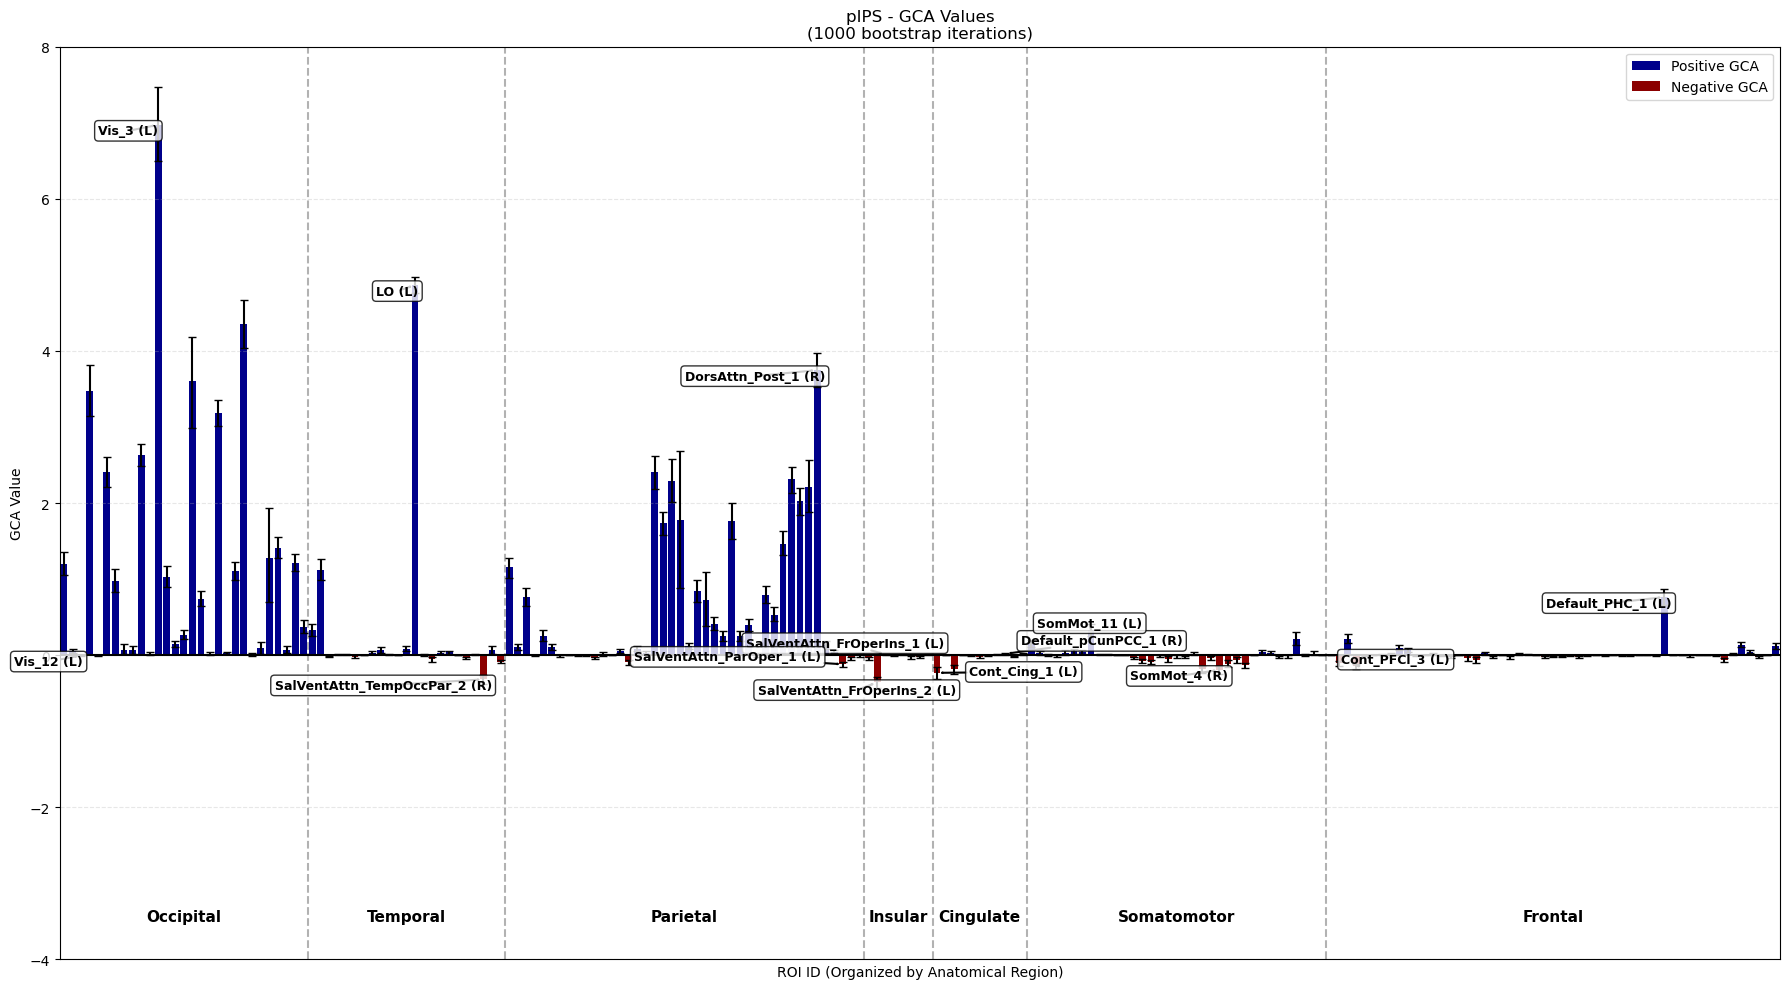

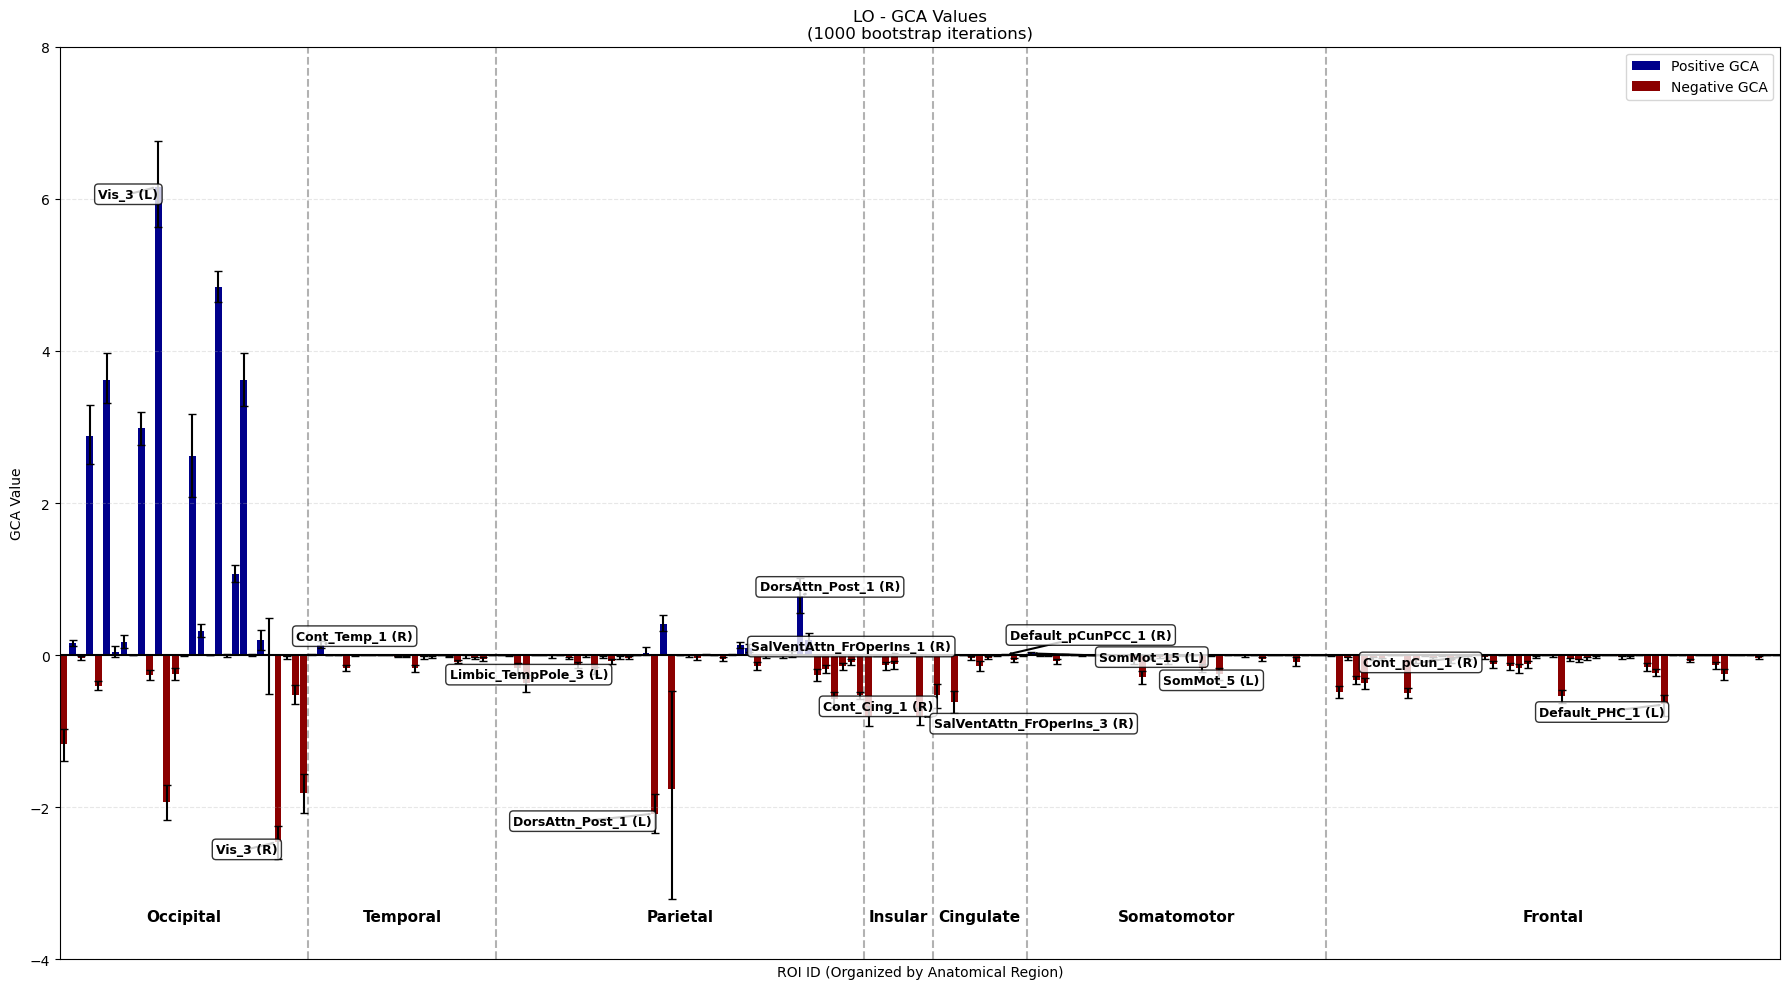

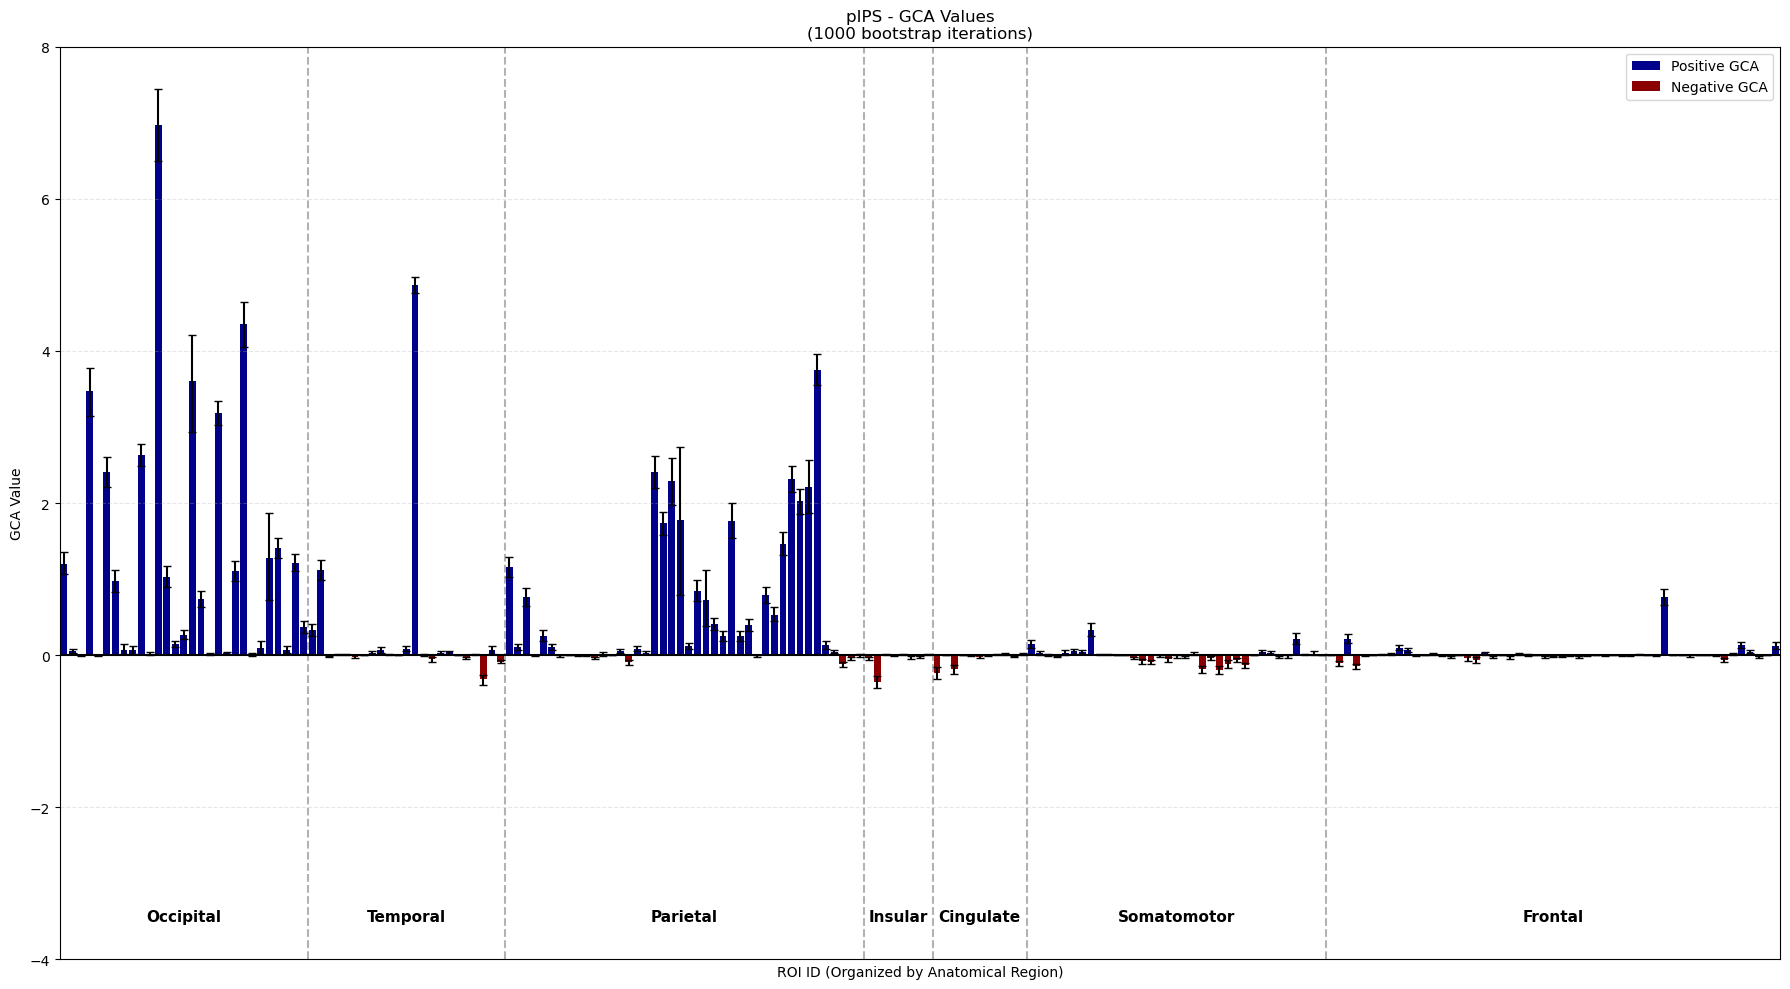

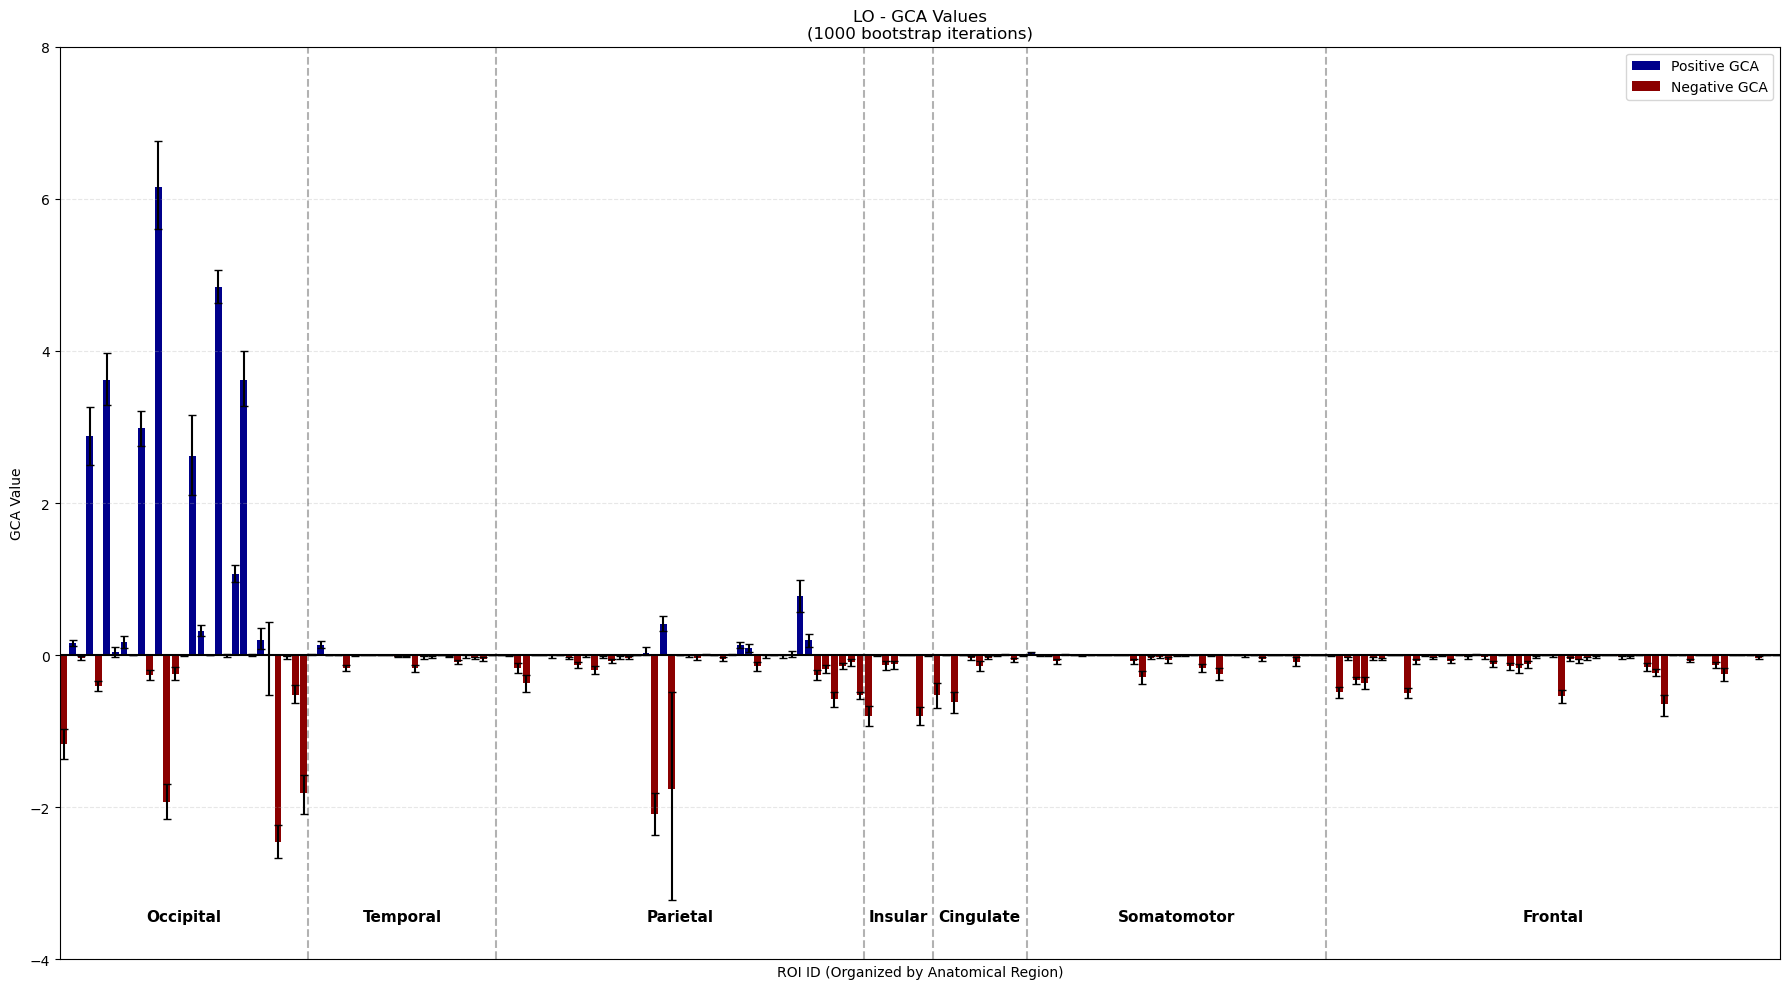

In [73]:
# Cell 7: Run the GCA anatomical organization visualization
plot_gca_anatomical_organization_enhanced(
    roi_values=roi_values,
    atlas_labels=atlas_labels,
    output_dir=results_dir,
    bootstrap_iterations=1000
)

plot_gca_anatomical_organization_enhanced_nolabel(
    roi_values=roi_values,
    atlas_labels=atlas_labels,
    output_dir=results_dir,
    bootstrap_iterations=1000
)
